In [86]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from matplotlib import rc
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.patches import Rectangle


print ("Modules imported")

def convert_to_dict(line):
    # Split the line into key-value pairs
    pairs = line.split(';')
    # Split each pair into key and value and store in a dictionary
    return dict(pair.split('=') for pair in pairs)


# List of marker styles
# markers = ['o', 'v', '^', '<', '>', 's', 'p', '*', 'h', 'H', '+', 'x', 'D', 'd', '|', '_']
markers = ['o', 'v', '^', 's', 'p', '*', 'h', 'H', '+', 'x', 'D', 'd', '|', '_']
# List of colors
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
# List of linestyles
linestyles = ['-', '--', '-.', ':']
markerSize = 5
capSize=4       # Error bar cap size
fontSize = 10

figSize = (4, 2.5)
# figSize = (2.2, 2.2)
labelPadding = 4
# Specify the file path
wns3DutyCycle_file = 'wns3DutyCycleResults.log'
dispLegend = False

rc('font',**{'family':'serif','serif':['Times New Roman']})


Modules imported


In [87]:

# Load the file as a DataFrame
with open(wns3DutyCycle_file, 'r') as f:
    DC_lines = f.readlines()

# Apply the convert_to_dict function to each line
DC_data = [convert_to_dict(line) for line in DC_lines]

# Convert the list of dictionaries into a DataFrame
DC_df = pd.DataFrame(DC_data)


# Convert necessary columns to numeric
list_of_numeric_columns = ['simID', 'videoQuality', 'twtWakeIntervalMultiplier', 'randSeed', 'nSTA', 'current_mA', 'TimeAwakeForThisSTA_us', 'TimeAsleepForThisSTA_us', 'TimeElapsedForThisSTA_us', 'ConfiguredDutyCycle', 'EffectiveDutyCycle', 'energyPerTotBit_JPerBit', 'UL_throughput_kbps', 'UL_latency_usPerPkt', 'UL_latency_90th_us', 'UL_latency_95th_us', 'UL_latency_99th_us', 'UplinkRetriesThisSta', 'UplinkExpiredMpduThisSta']

for column in list_of_numeric_columns:
    DC_df[column] = pd.to_numeric(DC_df[column], errors='coerce')



# Sort the data frame in ascending order of ConfiguredDutyCycle
DC_df = DC_df.sort_values(by='ConfiguredDutyCycle')


# Fetch sorted unique values of ConfiguredDutyCycle for plotting
ConfiguredDutyCycle_unique = DC_df['ConfiguredDutyCycle'].unique()
print (ConfiguredDutyCycle_unique)

# Delete all rows where ConfiguredDutyCycle_unique is 0.04, 0.06, 0.08, 0.09 - Plots look crowded
# DC_df = DC_df[DC_df['ConfiguredDutyCycle'] != 0.04]
# DC_df = DC_df[DC_df['ConfiguredDutyCycle'] != 0.06]
# DC_df = DC_df[DC_df['ConfiguredDutyCycle'] != 0.08]
DC_df = DC_df[DC_df['ConfiguredDutyCycle'] != 0.09]



# Fetch sorted unique values of twtWakeIntervalMultiplier for plotting
twtWakeIntervalMultiplier_unique = DC_df['twtWakeIntervalMultiplier'].unique()
print (twtWakeIntervalMultiplier_unique)


# Print all the column headers
# print(df.columns)




[0.005 0.01  0.015 0.02  0.025 0.03  0.04  0.05  0.06  0.07  0.08  0.09
 0.1   0.2   0.3   0.4   0.5   0.6   0.7   0.8   0.9   1.   ]
[1.  0.5]


    ConfiguredDutyCycle_percent  UL_throughput_mbps    CI_low   CI_high
0                           0.5            0.129024  0.001000  0.001000
1                           1.0            0.473350  0.004515  0.004515
2                           1.5            0.813110  0.019991  0.019991
3                           2.0            1.088694  0.049217  0.049217
4                           2.5            1.401282  0.055806  0.055806
5                           3.0            1.644300  0.066770  0.066770
6                           4.0            1.872325  0.049248  0.049248
7                           5.0            1.899917  0.037886  0.037886
8                           6.0            1.934549  0.020899  0.020899
9                           7.0            1.917489  0.036615  0.036615
10                          8.0            1.921247  0.036693  0.036693
11                         10.0            1.932141  0.032657  0.032657
12                         20.0            1.953113  0.015650  0

<Figure size 640x480 with 0 Axes>

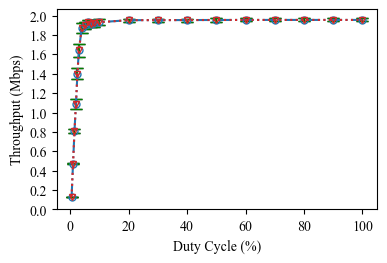

In [92]:
# Plot throughput - with confidence interval (alpha = 0.05)
# plt.figure(figsize=figSize)
plt.figure()
fig, ax = plt.subplots(figsize=figSize)
plt.subplots_adjust(left=0.15, right=0.95, top=0.9, bottom=0.1)

# Plotting the metrics for twtWakeIntervalMultiplier = 1
wakeIntMult = 1
DC_df_thisWakeInt = DC_df[DC_df['twtWakeIntervalMultiplier'] == wakeIntMult]

# For every unique value of ConfiguredDutyCycle, calculate the mean throughput and 95% confidence interval. Create a new data frame to store the mean throughput and confidence interval for each ConfiguredDutyCycle
x_percent = []
y = []
yerr_low = []
yerr_high = []
for i, dc in enumerate(DC_df_thisWakeInt['ConfiguredDutyCycle'].unique()):
    DC_df_thisDC = DC_df_thisWakeInt[DC_df_thisWakeInt['ConfiguredDutyCycle'] == dc]
    mean_throughput = DC_df_thisDC['UL_throughput_kbps'].mean()
    
    # Calculate the standard error of the mean
    sem = stats.sem(DC_df_thisDC['UL_throughput_kbps'])
    
    # Calculate the degrees of freedom
    df = len(DC_df_thisDC['UL_throughput_kbps']) - 1
    
    # Calculate the 95% confidence interval
    ci_low, ci_high = stats.t.interval(0.95, df, loc=mean_throughput, scale=sem)
    # Print as a dict
    # print({'ConfiguredDutyCycle': dc, 'UL_throughput_kbps': mean_throughput, 'CI_low': ci_low, 'CI_high': ci_high})
    x_percent.append(dc*100)
    y.append(mean_throughput/1000)
    yerr_low.append((mean_throughput - ci_low)/1000)
    yerr_high.append((ci_high - mean_throughput)/1000)

# Create a dataframe with the calculated values
DC_throughput_df_t_b = pd.DataFrame({'ConfiguredDutyCycle_percent': x_percent, 'UL_throughput_mbps': y, 'CI_low': yerr_low, 'CI_high': yerr_high})

# Pretty Print the dataframe completely
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(DC_throughput_df_t_b)


# Plot
plt.errorbar(x_percent, y, yerr=[yerr_low, yerr_high], color=colors[0], ecolor='black', marker=markers[0], markersize=markerSize, markerfacecolor='none', label=r'Wake Interval $=t_b$' , linestyle=linestyles[2], capsize=capSize)


# Plotting the metrics for twtWakeIntervalMultiplier = 0.5
wakeIntMult = 0.5
DC_df_thisWakeInt = DC_df[DC_df['twtWakeIntervalMultiplier'] == wakeIntMult]

# For every unique value of ConfiguredDutyCycle, calculate the mean throughput and 95% confidence interval. Create a new data frame to store the mean throughput and confidence interval for each ConfiguredDutyCycle
x_percent2 = []
y2 = []
yerr_low2 = []
yerr_high2 = []
for i, dc in enumerate(DC_df_thisWakeInt['ConfiguredDutyCycle'].unique()):
    DC_df_thisDC = DC_df_thisWakeInt[DC_df_thisWakeInt['ConfiguredDutyCycle'] == dc]
    mean_throughput = DC_df_thisDC['UL_throughput_kbps'].mean()
    
    # Calculate the standard error of the mean
    sem = stats.sem(DC_df_thisDC['UL_throughput_kbps'])
    
    # Calculate the degrees of freedom
    df = len(DC_df_thisDC['UL_throughput_kbps']) - 1
    
    # Calculate the 95% confidence interval
    ci_low, ci_high = stats.t.interval(0.95, df, loc=mean_throughput, scale=sem)
    # Print as a dict
    # print({'ConfiguredDutyCycle': dc, 'UL_throughput_kbps': mean_throughput, 'CI_low': ci_low, 'CI_high': ci_high})
    x_percent2.append(dc*100)
    y2.append(mean_throughput/1000)
    yerr_low2.append((mean_throughput - ci_low)/1000)
    yerr_high2.append((ci_high - mean_throughput)/1000)

# Create a dataframe with the calculated values
DC_throughput_df_half_t_b = pd.DataFrame({'ConfiguredDutyCycle_percent': x_percent2, 'UL_throughput_mbps': y2, 'CI_low': yerr_low2, 'CI_high': yerr_high2})

# Pretty Print the dataframe completely
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(DC_throughput_df_half_t_b)


# Plot
plt.errorbar(x_percent, y, yerr=[yerr_low, yerr_high], color=colors[3], ecolor='green', marker=markers[1], markersize=markerSize, markerfacecolor='none', label=r'Wake Interval $=t_b/2$' , linestyle=linestyles[3], capsize=capSize)



# Set yticks in steps of 0.2 from the range of x
plt.yticks(np.arange(0, 2.1, 0.2))
plt.rcParams['font.size'] = fontSize
plt.xlabel('Duty Cycle (%)', labelpad=labelPadding)
plt.ylabel('Throughput (Mbps)', labelpad=labelPadding)
# plt.title('Throughput vs Duty Cycle (%)')
if dispLegend:
    plt.legend()
    # Display the legend outside the plot, two columns, horizontal layout, no frame
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.25), ncol=4, frameon=False)


    


plt.savefig('wns3Apr2024DcThroughput.eps', format='eps', bbox_inches='tight')
# # Save as a png file
# plt.savefig('wns3Apr2024DcLegend.png', format='png', bbox_inches='tight')
    

    ConfiguredDutyCycle_percent  UL_latency_95th_ms     CI_low    CI_high
0                           0.5          922.046000   0.012428   0.012428
1                           1.0          921.214000   2.625880   2.625880
2                           1.5          918.490000  14.385039  14.385039
3                           2.0          681.828000  28.223543  28.223543
4                           2.5          484.332000  14.072001  14.072001
5                           3.0          336.277000  10.138955  10.138955
6                           4.0          176.562245   3.962459   3.962459
7                           5.0          121.186869   2.610930   2.610930
8                           6.0          100.342857   1.305463   1.305463
9                           7.0           94.911111   0.426433   0.426433
10                          8.0           92.628571   0.209404   0.209404
11                         10.0           89.706000   0.153096   0.153096
12                         20.0       

/var/folders/9m/mvnj824128zg3wjlg09g73lr0000gn/T/ipykernel_62466/3437945690.py:118: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


<Figure size 640x480 with 0 Axes>

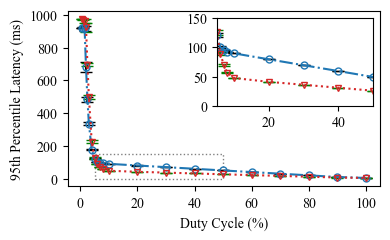

In [89]:
# Plot 95th percentile latency - with confidence interval (alpha = 0.05)
# plt.figure(figsize=figSize)
plt.figure()
fig, ax = plt.subplots(figsize=figSize)
plt.subplots_adjust(left=0.15, right=0.95, top=0.9, bottom=0.1)

# Plotting the metrics for twtWakeIntervalMultiplier = 1
wakeIntMult = 1
DC_df_thisWakeInt = DC_df[DC_df['twtWakeIntervalMultiplier'] == wakeIntMult]

# For every unique value of ConfiguredDutyCycle, calculate the mean 95th percentile latency and 95% confidence interval. Create a new data frame to store the mean latency95 and confidence interval for each ConfiguredDutyCycle
x_percent = []
y = []
yerr_low = []
yerr_high = []
for i, dc in enumerate(DC_df_thisWakeInt['ConfiguredDutyCycle'].unique()):
    DC_df_thisDC = DC_df_thisWakeInt[DC_df_thisWakeInt['ConfiguredDutyCycle'] == dc]
    mean_latency95 = DC_df_thisDC['UL_latency_95th_us'].mean()
    
    # Calculate the standard error of the mean
    sem = stats.sem(DC_df_thisDC['UL_latency_95th_us'])
    
    # Calculate the degrees of freedom
    df = len(DC_df_thisDC['UL_latency_95th_us']) - 1
    
    # Calculate the 95% confidence interval
    ci_low, ci_high = stats.t.interval(0.95, df, loc=mean_latency95, scale=sem)

    x_percent.append(dc*100)
    y.append(mean_latency95/1000)
    yerr_low.append((mean_latency95 - ci_low)/1000)
    yerr_high.append((ci_high - mean_latency95)/1000)

# Create a dataframe with the calculated values
DC_latency95_df_t_b = pd.DataFrame({'ConfiguredDutyCycle_percent': x_percent, 'UL_latency_95th_ms': y, 'CI_low': yerr_low, 'CI_high': yerr_high})

# Pretty Print the dataframe completely
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(DC_latency95_df_t_b)


# Plot
plt.errorbar(x_percent, y, yerr=[yerr_low, yerr_high], color=colors[0], ecolor='black', marker=markers[0], markersize=markerSize, markerfacecolor='none', label=r'Wake Interval $=t_b$' , linestyle=linestyles[2], capsize=capSize)



# Plotting the metrics for twtWakeIntervalMultiplier = 0.5
wakeIntMult = 0.5
DC_df_thisWakeInt = DC_df[DC_df['twtWakeIntervalMultiplier'] == wakeIntMult]

# For every unique value of ConfiguredDutyCycle, calculate the mean latency95 and 95% confidence interval. Create a new data frame to store the mean latency95 and confidence interval for each ConfiguredDutyCycle
x_percent2 = []
y2 = []
yerr_low2 = []
yerr_high2 = []
for i, dc in enumerate(DC_df_thisWakeInt['ConfiguredDutyCycle'].unique()):
    DC_df_thisDC = DC_df_thisWakeInt[DC_df_thisWakeInt['ConfiguredDutyCycle'] == dc]
    mean_latency95 = DC_df_thisDC['UL_latency_95th_us'].mean()
    
    # Calculate the standard error of the mean
    sem = stats.sem(DC_df_thisDC['UL_latency_95th_us'])
    
    # Calculate the degrees of freedom
    df = len(DC_df_thisDC['UL_latency_95th_us']) - 1
    
    # Calculate the 95% confidence interval
    ci_low, ci_high = stats.t.interval(0.95, df, loc=mean_latency95, scale=sem)
    
    x_percent2.append(dc*100)
    y2.append(mean_latency95/1000)
    yerr_low2.append((mean_latency95 - ci_low)/1000)
    yerr_high2.append((ci_high - mean_latency95)/1000)

# Create a dataframe with the calculated values
DC_latency95_df_half_t_b = pd.DataFrame({'ConfiguredDutyCycle_percent': x_percent2, 'UL_latency_95th_ms': y2, 'CI_low': yerr_low2, 'CI_high': yerr_high2})

# Pretty Print the dataframe completely
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(DC_latency95_df_half_t_b)


# Plot
plt.errorbar(x_percent2, y2, yerr=[yerr_low2, yerr_high2], color=colors[3], ecolor='green', marker=markers[1], markersize=markerSize, markerfacecolor='none', label=r'Wake Interval $=t_b/2$' , linestyle=linestyles[3], capsize=capSize)

# # Specify the range of x and y values for the inset plot
xlim1, xlim2, ylim1, ylim2 = 5, 50, 0, 150  
rectangle = Rectangle((xlim1, ylim1), xlim2-xlim1, ylim2-ylim1, fill=False, edgecolor='gray', linestyle='dotted')
# Add the rectangle to the plot
ax.add_patch(rectangle)

plt.rcParams['font.size'] = fontSize
ax.set_xlabel('Duty Cycle (%)', labelpad=labelPadding)
ax.set_ylabel('95th Percentile Latency (ms)', labelpad=labelPadding)
if dispLegend:
    plt.legend()
    # Display the legend outside the plot, two columns, horizontal layout, no frame
    
# For inset plot
axins = inset_axes(ax, width="50%", height="50%", loc='upper right')  # specify the position, width and height of the inset plot

# # Turn off the axis labels for the inset plot
axins.set_xlabel('')
axins.set_ylabel('')


axins.set_xlim(xlim1, xlim2)
axins.set_ylim(ylim1, ylim2)

# # Plot the same data in the inset plot
axins.errorbar(x_percent, y, yerr=[yerr_low, yerr_high], color=colors[0], ecolor='black', marker=markers[0], markersize=markerSize, markerfacecolor='none', label=r'Wake Interval $=t_b$' , linestyle=linestyles[2], capsize=capSize)

# print (x_percent2)
# print (y2)
axins.errorbar(x_percent2, y2, yerr=[yerr_low2, yerr_high2], color=colors[3], ecolor='green', marker=markers[1], markersize=markerSize, markerfacecolor='none', label=r'Wake Interval $=t_b/2$' , linestyle=linestyles[3], capsize=capSize)


# Use tight frame
plt.tight_layout()

plt.savefig('wns3Apr2024DcLatency.eps', format='eps', bbox_inches='tight')

    ConfiguredDutyCycle_percent  energyPerTotBit_JPerBit    CI_low   CI_high
0                           0.5                17.997883  0.072201  0.072201
1                           1.0                11.589950  0.063114  0.063114
2                           1.5                10.512461  0.183653  0.183653
3                           2.0                10.452896  0.338944  0.338944
4                           2.5                 9.987496  0.256187  0.256187
5                           3.0                 9.943371  0.280686  0.280686
6                           4.0                10.187917  0.270708  0.270708
7                           5.0                10.823885  0.190893  0.190893
8                           6.0                11.437787  0.064652  0.064652
9                           7.0                12.341937  0.256911  0.256911
10                          8.0                13.105092  0.293461  0.293461
11                         10.0                14.575989  0.338849  0.338849

<Figure size 640x480 with 0 Axes>

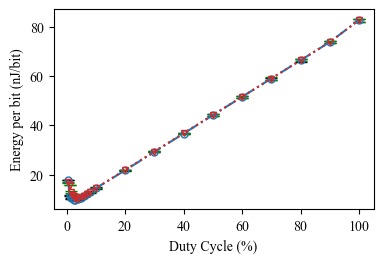

In [90]:
# Plot energyPerBit - with confidence interval (alpha = 0.05)
# plt.figure(figsize=figSize)
plt.figure()
fig, ax = plt.subplots(figsize=figSize)
plt.subplots_adjust(left=0.15, right=0.95, top=0.9, bottom=0.1)

# Plotting the metrics for twtWakeIntervalMultiplier = 1
wakeIntMult = 1
DC_df_thisWakeInt = DC_df[DC_df['twtWakeIntervalMultiplier'] == wakeIntMult]

# For every unique value of ConfiguredDutyCycle, calculate the mean 95th percentile latency and 95% confidence interval. Create a new data frame to store the mean energyPerBit and confidence interval for each ConfiguredDutyCycle
x_percent = []
y = []
yerr_low = []
yerr_high = []
for i, dc in enumerate(DC_df_thisWakeInt['ConfiguredDutyCycle'].unique()):
    DC_df_thisDC = DC_df_thisWakeInt[DC_df_thisWakeInt['ConfiguredDutyCycle'] == dc]
    mean_energyPerBit = DC_df_thisDC['energyPerTotBit_JPerBit'].mean()
    
    # Calculate the standard error of the mean
    sem = stats.sem(DC_df_thisDC['energyPerTotBit_JPerBit'])
    
    # Calculate the degrees of freedom
    df = len(DC_df_thisDC['energyPerTotBit_JPerBit']) - 1
    
    # Calculate the 95% confidence interval
    ci_low, ci_high = stats.t.interval(0.95, df, loc=mean_energyPerBit, scale=sem)

    x_percent.append(dc*100)
    y.append(mean_energyPerBit*1e9)
    yerr_low.append((mean_energyPerBit - ci_low)*1e9)
    yerr_high.append((ci_high - mean_energyPerBit)*1e9)

# Create a dataframe with the calculated values
DC_energyPerBit_df_t_b = pd.DataFrame({'ConfiguredDutyCycle_percent': x_percent, 'energyPerTotBit_JPerBit': y, 'CI_low': yerr_low, 'CI_high': yerr_high})

# Pretty Print the dataframe completely
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(DC_energyPerBit_df_t_b)


# Plot
plt.errorbar(x_percent, y, yerr=[yerr_low, yerr_high], color=colors[0], ecolor='black', marker=markers[0], markersize=markerSize, markerfacecolor='none', label=r'Wake Interval $=t_b$' , linestyle=linestyles[2], capsize=capSize)


# Plotting the metrics for twtWakeIntervalMultiplier = 0.5
wakeIntMult = 0.5
DC_df_thisWakeInt = DC_df[DC_df['twtWakeIntervalMultiplier'] == wakeIntMult]

# For every unique value of ConfiguredDutyCycle, calculate the mean energyPerBit and 95% confidence interval. Create a new data frame to store the mean energyPerBit and confidence interval for each ConfiguredDutyCycle
x_percent = []
y = []
yerr_low = []
yerr_high = []
for i, dc in enumerate(DC_df_thisWakeInt['ConfiguredDutyCycle'].unique()):
    DC_df_thisDC = DC_df_thisWakeInt[DC_df_thisWakeInt['ConfiguredDutyCycle'] == dc]
    mean_energyPerBit = DC_df_thisDC['energyPerTotBit_JPerBit'].mean()
    
    # Calculate the standard error of the mean
    sem = stats.sem(DC_df_thisDC['energyPerTotBit_JPerBit'])
    
    # Calculate the degrees of freedom
    df = len(DC_df_thisDC['energyPerTotBit_JPerBit']) - 1
    
    # Calculate the 95% confidence interval
    ci_low, ci_high = stats.t.interval(0.95, df, loc=mean_energyPerBit, scale=sem)
    
    x_percent.append(dc*100)
    y.append(mean_energyPerBit*1e9)
    yerr_low.append((mean_energyPerBit - ci_low)*1e9)
    yerr_high.append((ci_high - mean_energyPerBit)*1e9)

# Create a dataframe with the calculated values
DC_energyPerBit_df_half_t_b = pd.DataFrame({'ConfiguredDutyCycle_percent': x_percent, 'energyPerTotBit_JPerBit': y, 'CI_low': yerr_low, 'CI_high': yerr_high})

# Pretty Print the dataframe completely
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(DC_energyPerBit_df_half_t_b)


# Plot
plt.errorbar(x_percent, y, yerr=[yerr_low, yerr_high], color=colors[3], ecolor='green', marker=markers[1], markersize=markerSize, markerfacecolor='none', label=r'Wake Interval $=t_b/2$' , linestyle=linestyles[3], capsize=capSize)



# Set yticks in steps of 0.2 from the range of x
# plt.yticks(np.arange(0, 2.1, 0.2))

plt.rcParams['font.size'] = fontSize
plt.xlabel('Duty Cycle (%)', labelpad=labelPadding)
plt.ylabel('Energy per bit (nJ/bit)', labelpad=labelPadding)
if dispLegend:
    plt.legend()
    # Display the legend outside the plot, two columns, horizontal layout, no frame
    # plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2, frameon=False)
    plt.legend(loc='lower right')

plt.savefig('wns3Apr2024DcEnergy.eps', format='eps', bbox_inches='tight')